# Hemocell One Cell Shear Simulation UQ Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lxml import etree

from SALib.sample import saltelli
from SALib.analyze import sobol

from sklearn.neighbors.kde import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from local_config import *

## Read data and results

In [2]:
method="TMCMC"
mode="visc"
tmax = 40000

imin = 3
imax = 10

# Load results from posterior sampling
sample_df = pd.read_csv("%s/%s_hemocell_samples_%s_%i_%i_tmax_%i.csv" % 
                        (outputpath,method,mode,imin,imax,tmax),sep=";")

qoi = np.load("%s/%s_hemocell_qoi_%s_%i_%i_tmax_%i.npy" % (outputpath,method,mode,imin,imax,tmax))

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Parameter names
params = ["kLink","kBend"]

if mode == "visc":
    params.append("viscosityRatio")

if method == "TMCMC":
    params = params + []

In [3]:
print(data)
print(sample_df)

    Treatment  Stress (pa)  EL Healthy  EL 100%  EL error (+/-)
45        0.5         0.30       0.038    0.119           0.015
46        0.5         0.44       0.077    0.050           0.004
47        0.5         0.64       0.151    0.031           0.003
48        0.5         0.93       0.196    0.063           0.004
49        0.5         1.36       0.268    0.128           0.004
50        0.5         1.99       0.332    0.190           0.003
51        0.5         2.91       0.389    0.251           0.005
52        0.5         4.24       0.441    0.321           0.004
53        0.5         6.19       0.485    0.384           0.003
54        0.5         9.04       0.521    0.440           0.003
55        0.5        13.20       0.549    0.487           0.002
56        0.5        19.28       0.576    0.523           0.004
57        0.5        28.15       0.598    0.554           0.002
58        0.5        41.10       0.620    0.581           0.002
59        0.5        60.00       0.639  

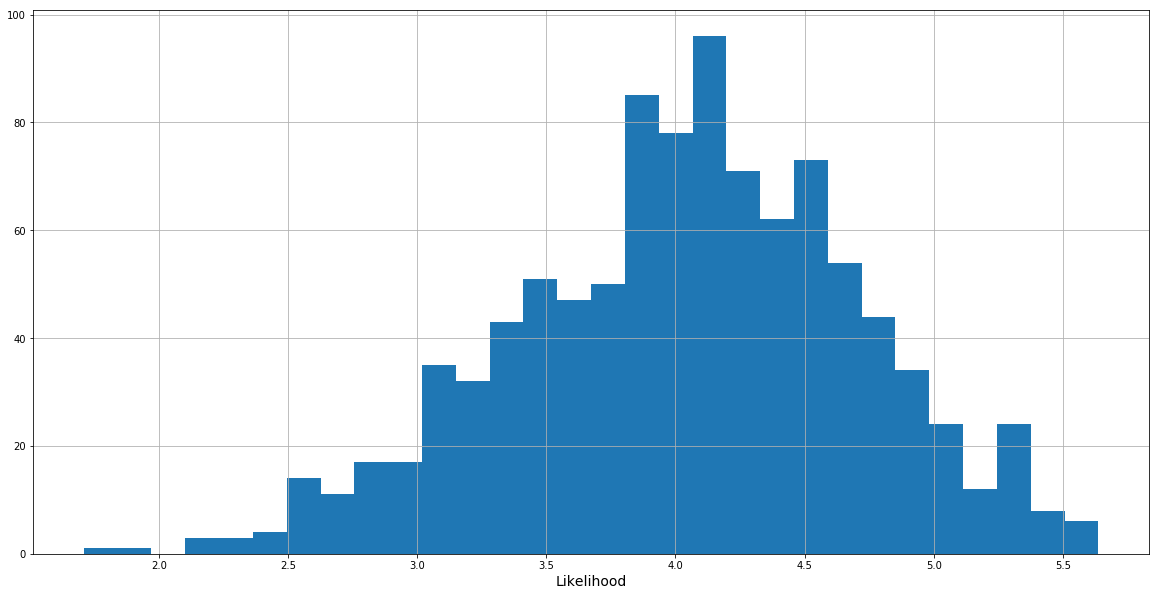

In [48]:
nbins = 30
plt.figure(figsize=(20,10))
plt.grid(True)

if method == "TMCMC":
    plt.xlabel("Likelihood",fontsize=14)
    plt.hist(np.log10(sample_df["likelihood"].values),bins=nbins)
elif method == "ABCSubSim":
    plt.xlabel("Distance",fontsize=14)
    plt.hist(sample_df["distance"].values,bins=nbins)
    
plt.show()

In [49]:
if method == "TMCMC":
    for n in range(-8,9):
        print("Number of high densities larger than %e:" % (10**n),np.sum(sample_df["likelihood"].values > 10**n))

Number of high densities larger than 1.000000e-08: 1000
Number of high densities larger than 1.000000e-07: 1000
Number of high densities larger than 1.000000e-06: 1000
Number of high densities larger than 1.000000e-05: 1000
Number of high densities larger than 1.000000e-04: 1000
Number of high densities larger than 1.000000e-03: 1000
Number of high densities larger than 1.000000e-02: 1000
Number of high densities larger than 1.000000e-01: 1000
Number of high densities larger than 1.000000e+00: 1000
Number of high densities larger than 1.000000e+01: 1000
Number of high densities larger than 1.000000e+02: 998
Number of high densities larger than 1.000000e+03: 933
Number of high densities larger than 1.000000e+04: 539
Number of high densities larger than 1.000000e+05: 74
Number of high densities larger than 1.000000e+06: 0
Number of high densities larger than 1.000000e+07: 0
Number of high densities larger than 1.000000e+08: 0


Best sample:
kLink                168.564987
kBend                346.451218
viscosityRatio         1.274226
err                    0.147650
likelihood        434229.023615
Name: 188, dtype: float64


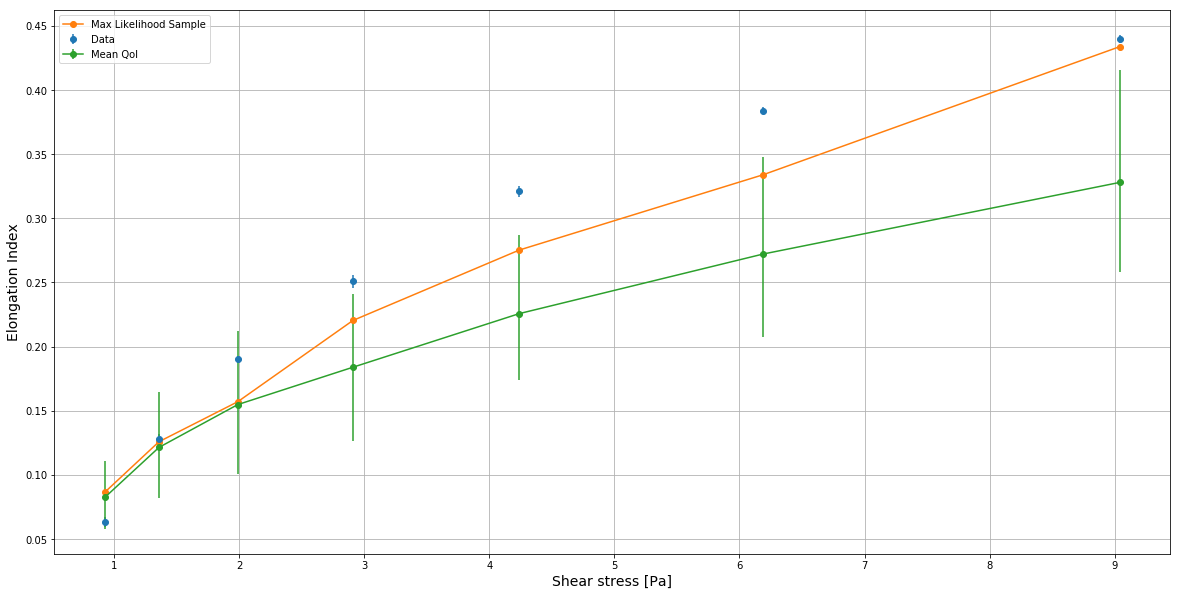

In [50]:
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")

# Highest likelihood
if method == "TMCMC":
    mle = np.argmax(sample_df["likelihood"].values)
    #print("Max likelihood:",sample_df["likelihood"].values[mle])
elif method == "ABCSubSim":
    mle = np.argmin(sample_df["distance"].values)
    #print("Minimum distance:",sample_df["distance"].values[mle])

print("Best sample:")
print(sample_df.loc[mle])
    
plt.plot(stress,qoi[mle],"o-",label="Max Likelihood Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

ptile = np.percentile(qoi,[2.5,97.5],axis=0)

ptile[0] = mean - ptile[0]
ptile[1] -= mean

plt.errorbar(stress,mean,yerr=ptile,fmt="o-",label="Mean QoI")

plt.legend()
plt.show()

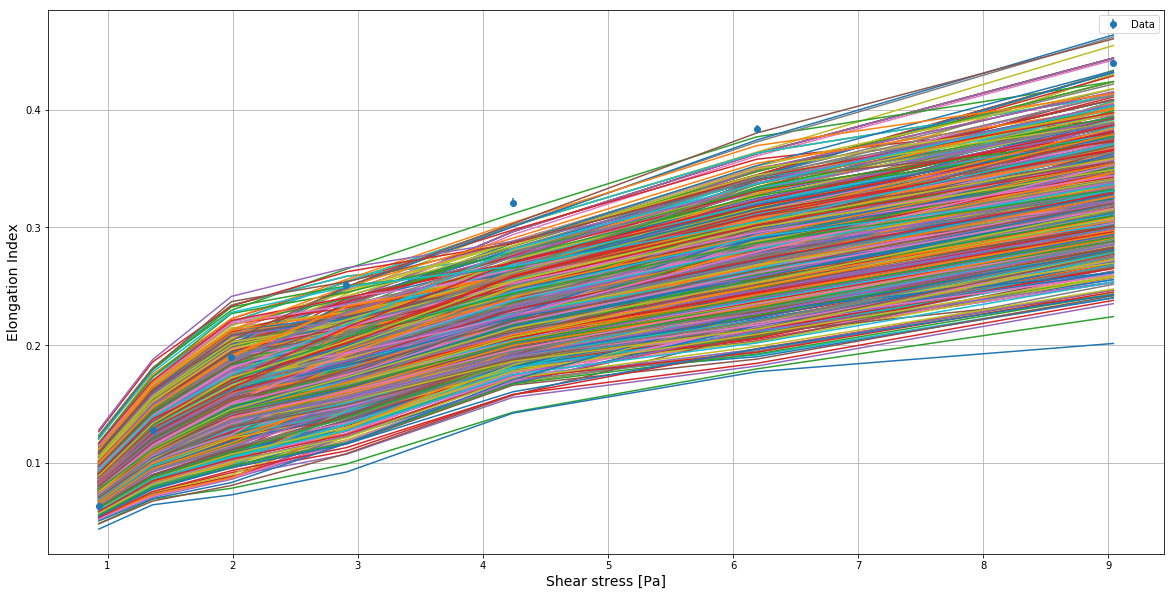

In [51]:
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Plot all qoi
for n in range(qoi.shape[0]):
    #if sample_df["viscosityRatio"].values[n] > 10 and sample_df["viscosityRatio"].values[n] < 50:
    plt.plot(stress,qoi[n])

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
plt.legend()

plt.show()

## Plot parameter histograms

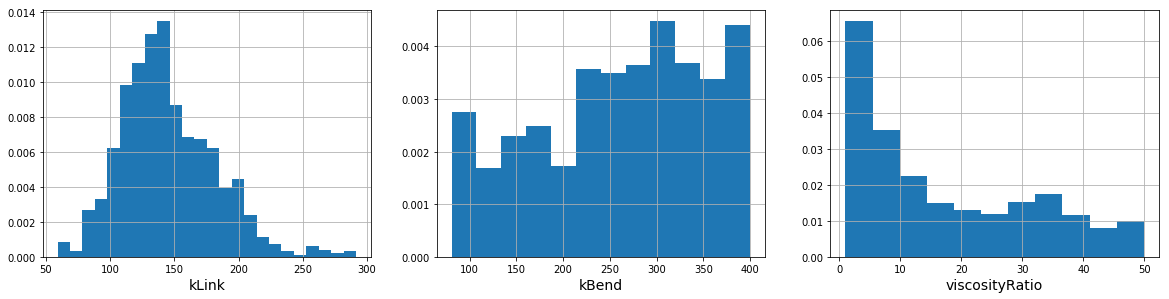

In [52]:
plt.figure(figsize=(20,10))
for n in range(len(params)):
    plt.subplot(2,3,n+1)
    plt.grid(True)
    plt.xlabel(params[n],fontsize=14)
    plt.hist(sample_df[params[n]].values,bins="auto",density=True)
    
plt.show()

## Plot parameters against each other in 2D

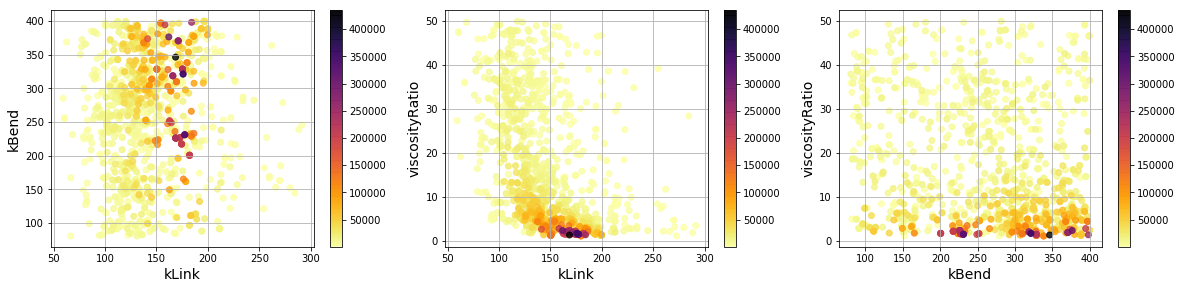

In [53]:
plt.figure(figsize=(20,20))

count = 1
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            plt.subplot(4,3,count)
            plt.grid(True)
            plt.xlabel(params[n],fontsize=14)
            plt.ylabel(params[m],fontsize=14)
            if method == "TMCMC":
                order = np.argsort(sample_df["likelihood"])
                plt.scatter(sample_df[params[n]].values[order],sample_df[params[m]].values[order],
                            c=sample_df["likelihood"].values[order],cmap="inferno_r",alpha=0.8)
                
            elif method == "ABCSubSim":
                order = np.argsort(sample_df["distance"])[::-1]
                plt.scatter(sample_df[params[n]].values[order],sample_df[params[m]].values[order],
                            c=sample_df["distance"].values[order],cmap="inferno")
                
            plt.colorbar()
            count += 1

plt.show()

## Gaussian Kernel Density Estimations

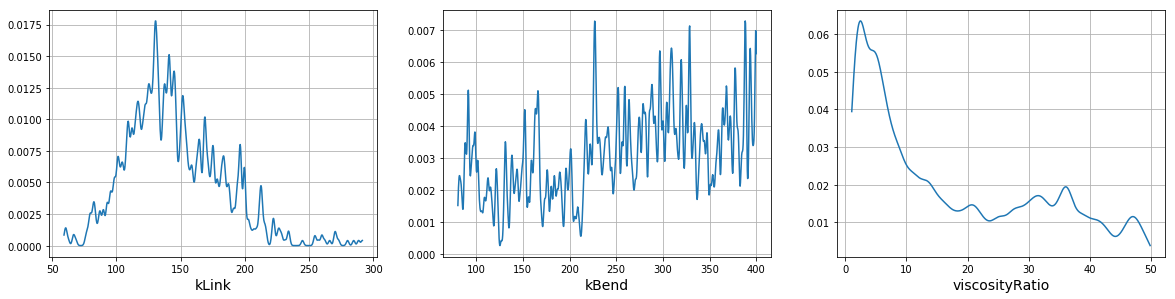

In [54]:
bandwidth = 1.0
plt.figure(figsize=(20,10))
for n in range(len(params)):
    vals = sample_df[params[n]].values
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(vals[:,None])
    x_vals = np.linspace(np.min(vals),np.max(vals),1000)
    y_vals = np.exp(kde.score_samples(x_vals[:,None]))
    
    plt.subplot(2,3,n+1)
    plt.grid(True)
    plt.xlabel(params[n],fontsize=14)
    plt.plot(x_vals,y_vals)
    
plt.show()

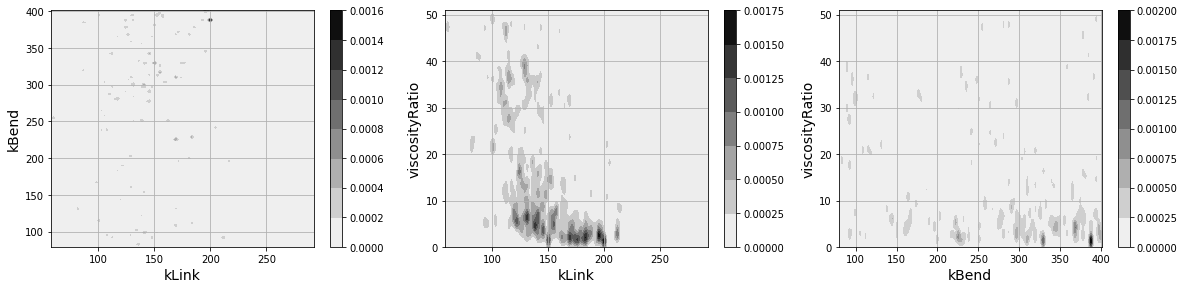

In [55]:
plt.figure(figsize=(20,20))

zoom = 1

count = 1
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            vals = sample_df[[params[n],params[m]]].values
            kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(vals)
            
            x = np.linspace(np.min(vals[:,0])-zoom,np.max(vals[:,0])+zoom,100)
            y = np.linspace(np.min(vals[:,1])-zoom,np.max(vals[:,1])+zoom,100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            grid_vals = np.exp(kde.score_samples(grid_flat)).reshape(xx.shape)
            
            #print(np.exp(kde.score_samples(grid_flat)))
            #print(xx.flatten())
            #print(grid_vals)
            
            plt.subplot(4,3,count)
            plt.grid(True)
            plt.xlabel(params[n],fontsize=14)
            plt.ylabel(params[m],fontsize=14)
            plt.contourf(xx,yy,grid_vals,cmap="gray_r")
            plt.colorbar()
            count += 1

plt.show()

# Sensitivity Analysis

In [14]:
imputation = "GP_model"

In [15]:
imin = 3
imax = 9

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

model_params = ["kLink","kBend","viscosityRatio"]

# Set the bounds on the parameters
bounds = [[15.0,300.0],
          [80.0,400.0],
          [1.0,50.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,1000,calc_second_order=False)

sobol_qoi = np.load("%s/sobol_hemocell_qoi_%s_%i_%i_tmax_%i.npy" % (outputpath,mode,imin,imax,tmax))

print("Crashed simulations:",np.sum(sobol_qoi == -100))

if imputation == "zero":
    sobol_qoi[sobol_qoi == -100] = 0
elif imputation == "GP_model":    
    # Load simulation data
    x_train = np.load("%s/train_hemocell_samples_%s_3_10_tmax_%i.npy" % (outputpath,mode,tmax))
    y_train = np.load("%s/train_hemocell_qoi_%s_3_10_tmax_%i.npy" % (outputpath,mode,tmax))

    # Remove failed simulation outputs
    x_train = x_train[(y_train >= 0)[:,0],:]
    y_train = y_train[y_train >= 0]
    
    # Train prediction model
    kernel = RBF(length_scale=1.0)
    predictionModel = GaussianProcessRegressor(kernel=kernel,alpha=1e-6).fit(x_train,y_train)
    
    sample_idx,var_idx = np.where(sobol_qoi < 0)
    for n in range(sample_idx.size):
        arr = np.array([*param_values[sample_idx[n]],shearrate[var_idx[n]]])[None,:]
        mean,std = predictionModel.predict(arr,return_std=True)
    
        sobol_qoi[sample_idx[n],var_idx[n]] = mean

print("Imputation sanity check:",np.sum(sobol_qoi == -100))

Crashed simulations: 10
Imputation sanity check: 0


In [16]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

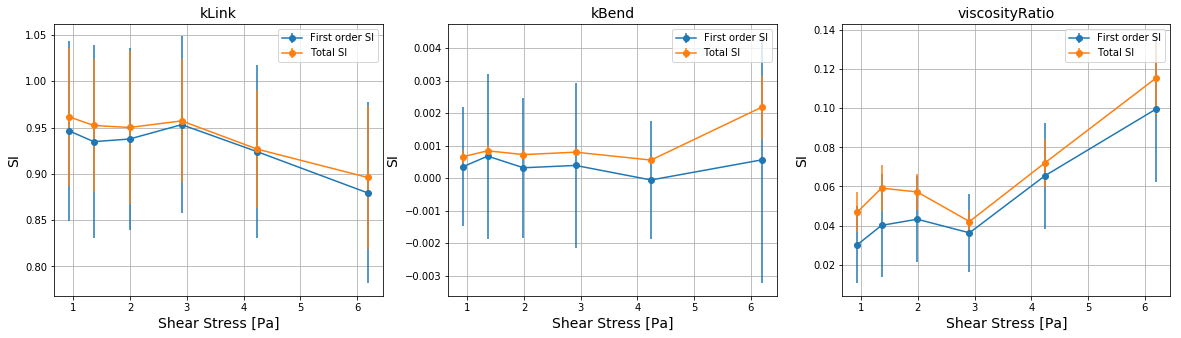

In [17]:
plt.figure(figsize=(20,5))
plt.title("Sobol indices",fontsize=14)
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(model_params[n],fontsize=14)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=14)
    plt.ylabel("SI",fontsize=14)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],fmt="o-",label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],fmt="o-",label="Total SI")
    
    plt.legend()

plt.show()

# Check convergence with Time

In [4]:
def plot_convergence(qoi,tmeas,tlist):
    plt.xlabel("Shear stress [Pa]",fontsize=13)
    plt.ylabel("Elongation Index",fontsize=13)
    plt.grid(True)
    
    for n,tmax in enumerate(np.arange(tmeas,200001,tmeas)):
        if tmax in tlist and not np.any(qoi[n] < 0):
            plt.plot(stress,qoi[n],label="t = " + str(int(tmax)))
    
    # Data
    plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
    plt.legend()

## Convergence without Interior Viscosity

$\kappa_b \approx 149.9$

$\kappa_l \approx 107.8$

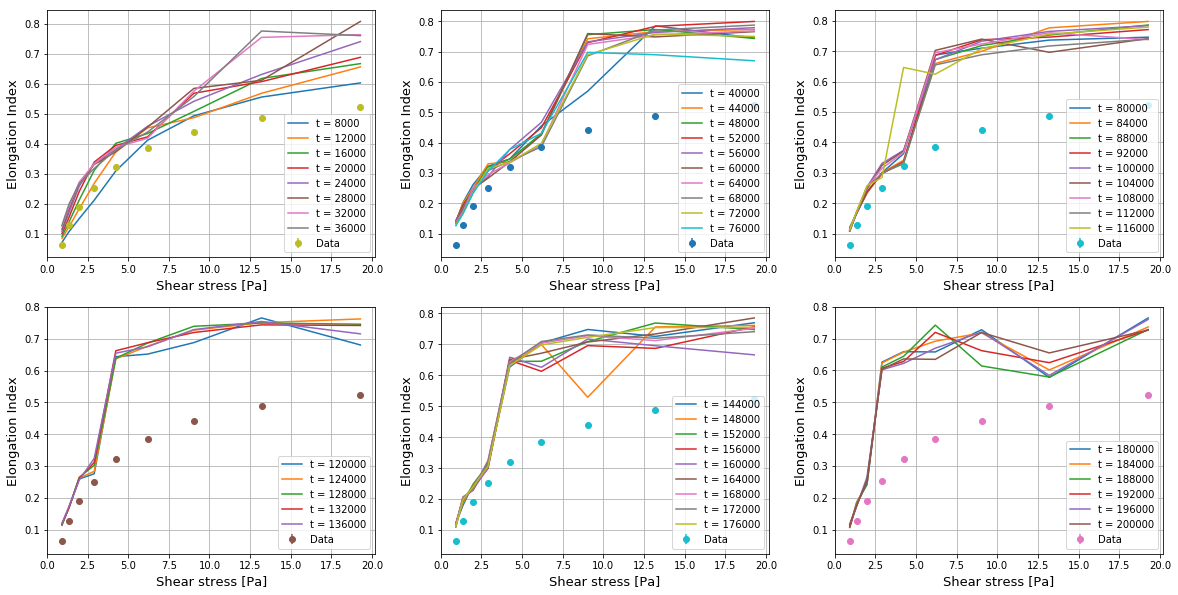

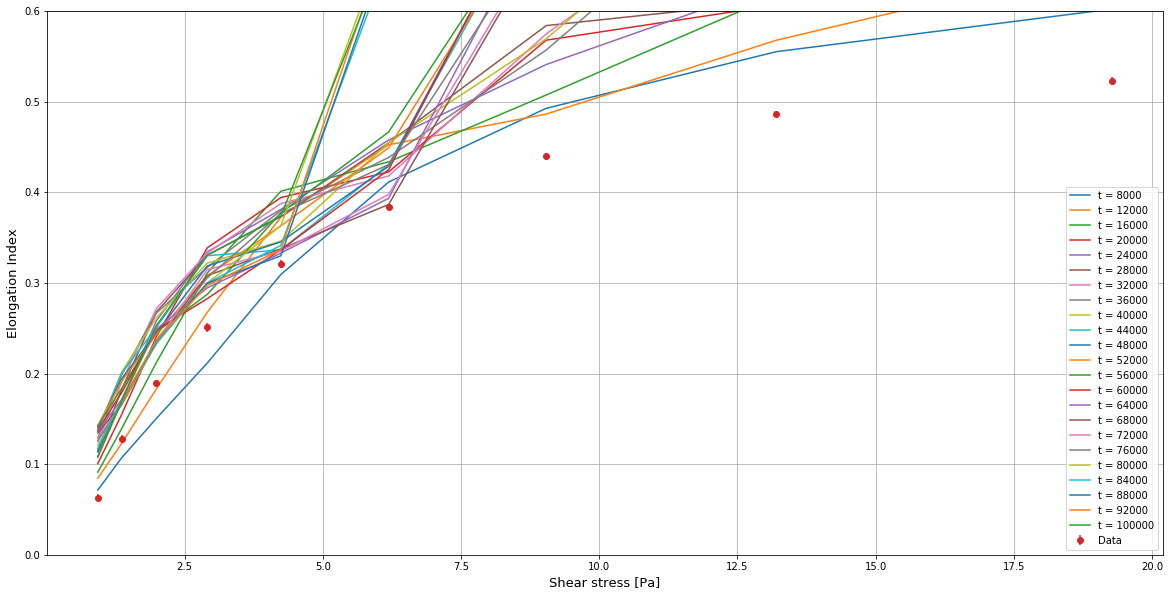

In [5]:
imin = 3
imax = 12

stress,el,el_err = data.values[imin:imax,[1,3,4]].T

convergence_qoi = np.load("%s/convergence_qoi_multi_sim.npy" % outputpath)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plot_convergence(convergence_qoi,4000,np.arange(8000,40000,4000))
plt.subplot(2,3,2)
plot_convergence(convergence_qoi,4000,np.arange(40000,80000,4000))
plt.subplot(2,3,3)
plot_convergence(convergence_qoi,4000,np.arange(80000,120000,4000))
plt.subplot(2,3,4)
plot_convergence(convergence_qoi,4000,np.arange(120000,140000,4000))
plt.subplot(2,3,5)
plot_convergence(convergence_qoi,4000,np.arange(140000,180000,4000))
plt.subplot(2,3,6)
plot_convergence(convergence_qoi,4000,np.arange(180000,200001,4000))
plt.show()

plt.figure(figsize=(20,10))
plt.ylim(0,0.6)
plot_convergence(convergence_qoi,4000,np.arange(8000,100001,4000))
plt.show()

## Convergence with Interior Viscosity

$\Lambda \approx 6.9$

$\kappa_b \approx 100.8$

$\kappa_l \approx 156.85 $

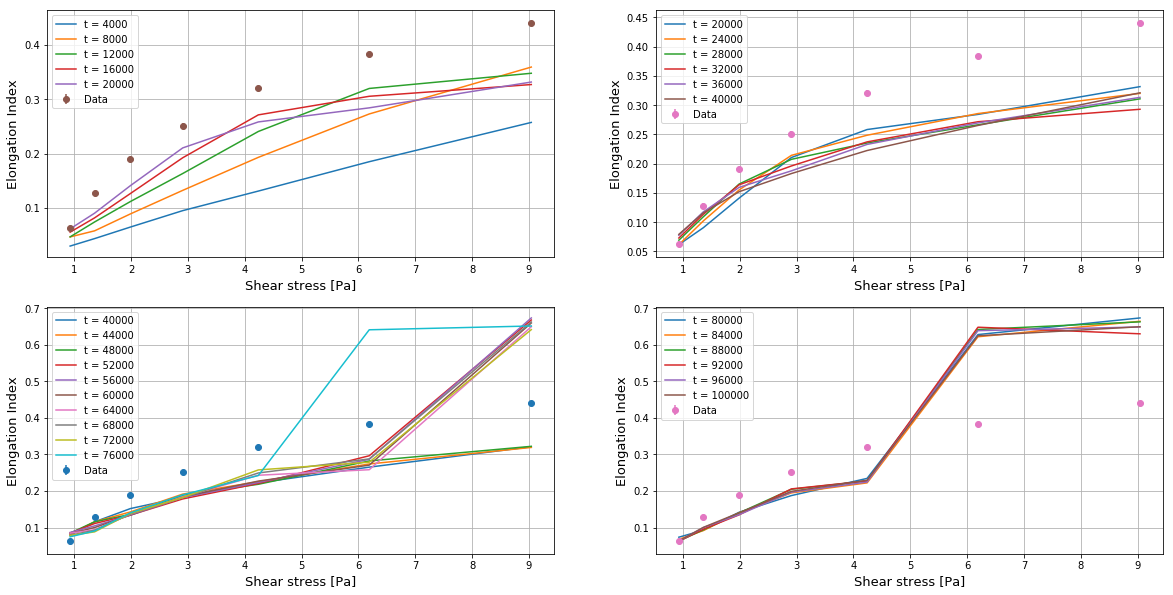

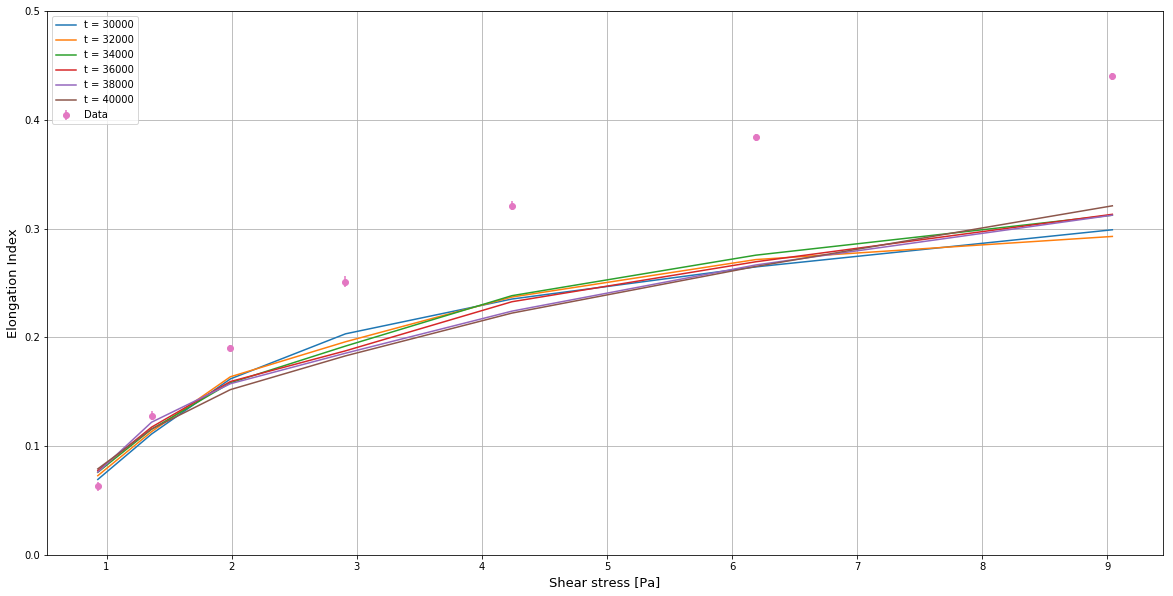

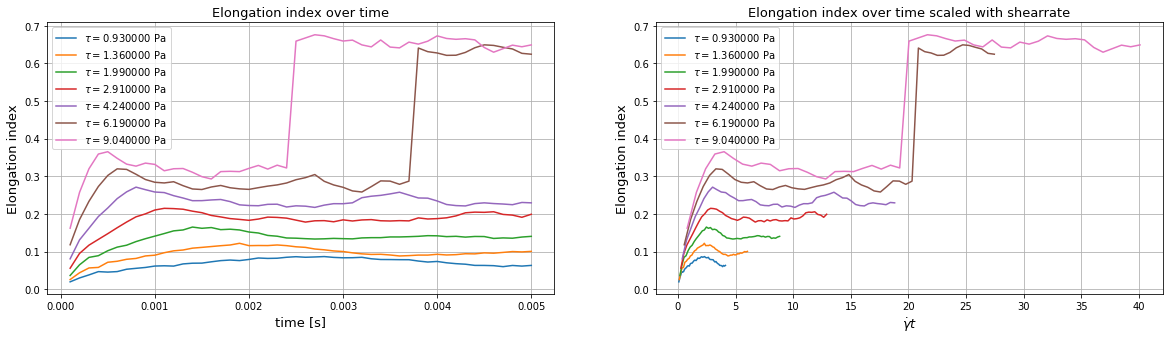

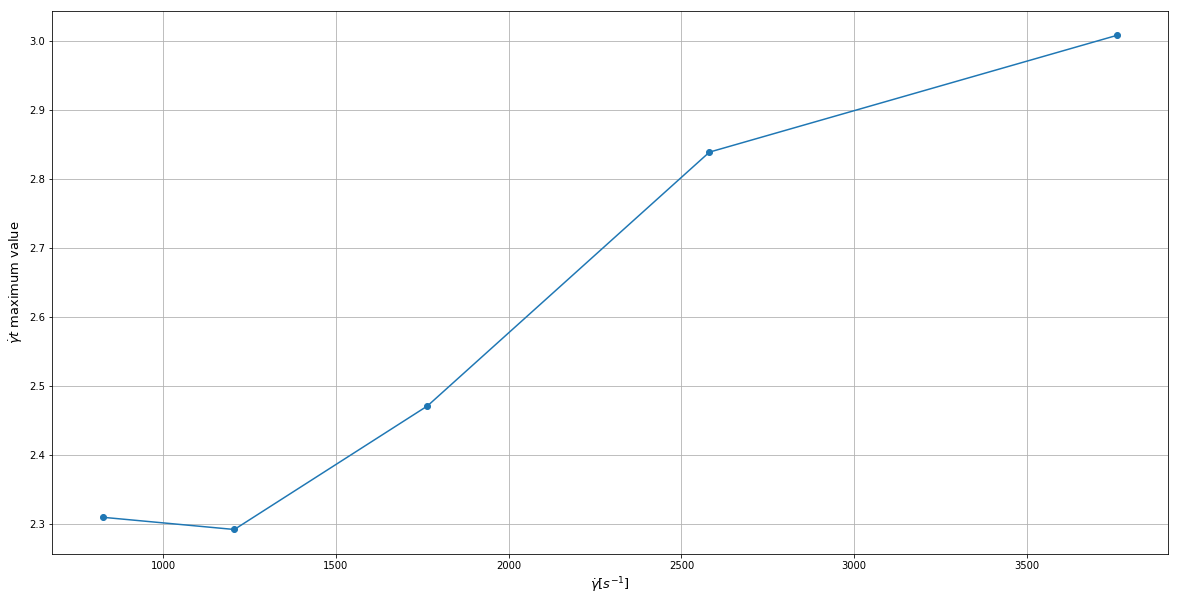

In [6]:
imin = 3
imax = 10

stress,el,el_err = data.values[imin:imax,[1,3,4]].T
convergence_qoi = np.load("%s/convergence_qoi_visc_%i_%i.npy" % (outputpath,imin,imax))

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plot_convergence(convergence_qoi,2000,np.arange(4000,20001,4000))
plt.subplot(2,2,2)
plot_convergence(convergence_qoi,2000,np.arange(20000,40001,4000))
plt.subplot(2,2,3)
plot_convergence(convergence_qoi,2000,np.arange(40000,80000,4000))
plt.subplot(2,2,4)
plot_convergence(convergence_qoi,2000,np.arange(80000,100001,4000))
plt.show()

plt.figure(figsize=(20,10))
plt.ylim(0,0.5)
plot_convergence(convergence_qoi,2000,np.arange(30000,40001,2000))
plt.show()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Elongation index over time",fontsize=13)
plt.xlabel("time [s]",fontsize=13)
plt.ylabel("Elongation index",fontsize=13)
plt.grid(True)

steps = np.arange(2000,100001,2000)

for n in range(7):
    plt.plot(steps[convergence_qoi[:,n] > 0] * 0.5e-7,
             convergence_qoi[:,n][convergence_qoi[:,n] > 0],label=r"$\tau = %f$ Pa" % (stress[n]))

plt.legend()

plt.subplot(1,2,2)
plt.title("Elongation index over time scaled with shearrate",fontsize=13)
plt.xlabel(r"$\dot{\gamma} t$",fontsize=13)
plt.ylabel("Elongation index",fontsize=13)
plt.grid(True)

steps = np.arange(2000,100001,2000)

for n in range(7):
    plt.plot(steps[convergence_qoi[:,n] > 0] * 0.5e-7 * shearrate[n],
             convergence_qoi[:,n][convergence_qoi[:,n] > 0],label=r"$\tau = %f$ Pa" % (stress[n]))

plt.legend()

plt.figure(figsize=(20,10))
plt.xlabel("$\dot{\gamma} [s^{-1}]$",fontsize=13)
plt.ylabel("$\dot{\gamma} t$ maximum value",fontsize=13)
plt.plot(shearrate[:-2],steps[convergence_qoi.argmax(axis=0)][:-2]*0.5e-7*shearrate[:-2],"o-")
plt.grid(True)

plt.show()

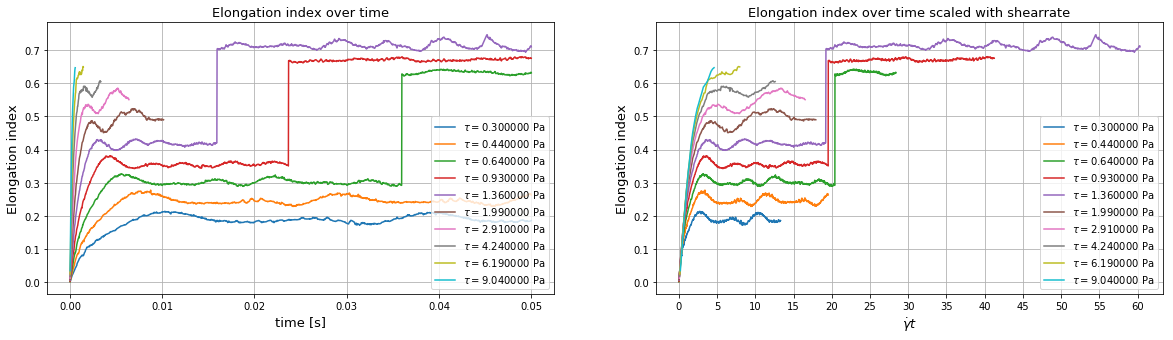

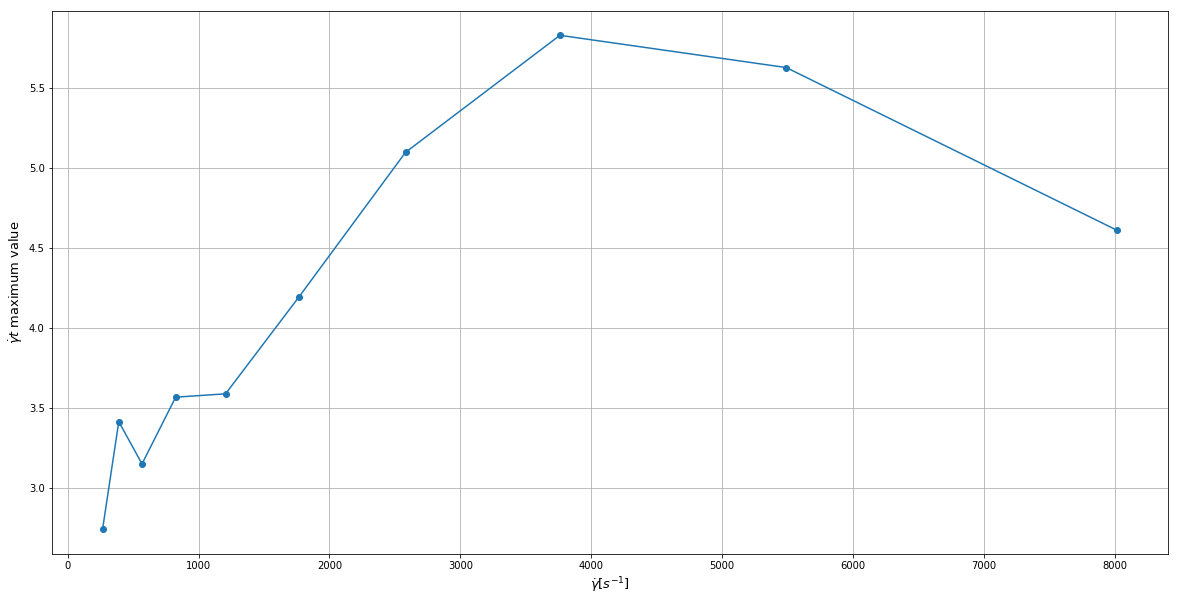

In [19]:
imin = 0
imax = 10

stress,el = data.values[imin:imax,[1,2]].T

el_err = np.zeros(imax-imin)

convergence_qoi = np.load("%s/convergence_qoi_visc_%i_%i.npy" % (outputpath,imin,imax))

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Elongation index over time",fontsize=13)
plt.xlabel("time [s]",fontsize=13)
plt.ylabel("Elongation index",fontsize=13)
plt.grid(True)

steps = np.arange(500,1000001,500)

for n in range(10):
    plt.plot(steps[convergence_qoi[:,n] > 0] * 0.5e-7,
             convergence_qoi[:,n][convergence_qoi[:,n] > 0],label=r"$\tau = %f$ Pa" % (stress[n]))

plt.legend()

plt.subplot(1,2,2)
plt.title("Elongation index over time scaled with shearrate",fontsize=13)
plt.xlabel(r"$\dot{\gamma} t$",fontsize=13)
plt.ylabel("Elongation index",fontsize=13)
plt.xticks(np.arange(0,101,5))
plt.grid(True)

steps = np.arange(500,1000001,500)

for n in range(10):
    plt.plot(steps[convergence_qoi[:,n] > 0] * 0.5e-7 * shearrate[n],
             convergence_qoi[:,n][convergence_qoi[:,n] > 0],label=r"$\tau = %f$ Pa" % (stress[n]))

plt.legend()

ivals = []
for n in range(10):
    max_idx = convergence_qoi[steps*0.5e-7*shearrate[n] < 7,n].argmax()
    ivals.append(max_idx)
    

plt.figure(figsize=(20,10))
plt.xlabel("$\dot{\gamma} [s^{-1}]$",fontsize=13)
plt.ylabel("$\dot{\gamma} t$ maximum value",fontsize=13)
plt.plot(shearrate,steps[ivals]*0.5e-7*shearrate,"o-")
plt.grid(True)

plt.show()